# Módulo  - Estatística II

## Projeto - Análise do dataset "Wine Quality"

### Instruções

- O projeto deverá ser entregue até dia 05/05;
- O projeto poderá ser feito __individualmente__ ou em __grupos__ de até __4 pessoas__;

### Informações sobre o projeto

Dataset (conjunto de dados a ser utilizado) está disponível em:
    https://archive.ics.uci.edu/ml/datasets/Wine+Quality

Data Set Information:

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link] or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.


Attribute Information:

Input variables (based on physicochemical tests): <br>
- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10 - sulphates
- 11 - alcohol

Output variable (based on sensory data): <br>
- 12 - quality (score between 0 and 10)

Para ajudar no desenvolvimento do projeto, vamos separar o projeto em algumas seções, conforme descritas a seguir:

- __Preparação dos Dados e Verificação de Consistência__: Neste tópico deve ser feita a verificação da consistência dos dados e caso necessário efetuar eventuais modificações na base de dados. Alguns dos procedimentos que podemos fazer aqui são: Remoção e/ou tratamento de valores faltantes, remoção de duplicatas, ajustes dos tipos de variáveis, análise de _outliers_ entre outras;

<br>

- __Análise Exploratória dos Dados__: Para fazermos a modelagem, precisamos conhecer muito bem os dados que estamos trabalhando. Por isso, nesta parte do projeto vocês desenvolveram an´laises e gráficos a respeito dos dados que estão utilizando. Tente tirar ao máximo informaç~eos sobre as variáveis em si e suas relações com as demais;

<br>

- __Modelagem dos Dados__: Nesta parte, o projeto será dividido em dois modelos, um de Regressão Linear e outra de Regressão Logística. No __primeiro módulo__, o objetivo será modelar um regressor que estime o valor da qualidade do vinho (para este primeiro modelo, desconsidere a variável `quality`). No __segundo modelo__, utilizando como variável resposta (_target_) a variável `quality`, modelar um classificador que separe entre vinhos bons e ruins (para isto, considere `quality` >= 6 como um vinho bom). Além disso, avaliar a necessidade ou não de aplicar regularizações no modelo.

<br>

- __Conclusões sobre o Projeto__: Para finalizar, descreva as suas conclusões sobre o desenvolvimento do modelo e os resultados obtidos.

<br>

__Importante:__ Façam as análise em ambas as bases `winequality-red.csv` e `winequality-white.csv` separadamente, e depois misturem os dados para uma nova análise (no total serão 3 análises a serem feitas).

<br>

A entrega deve ser feita em um arquivo _Jupyter Notebook_ em aba que será disponibilizada no Class, contendo todo o desenvolvimento do projeto e o nome(s) do(s) aluno(s).

#### Desenvolvido por: Marcelo Tatsuo Yonei 
##### Turma: 815  

### Bibliotecas e funções que serão utilizadas:

In [1]:
# Bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score, r2_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [2]:
def avaliar_outlier(df, col):
    '''
    A função retorna um dataframe contendo os seguintes valores:
     - Primeiro Quartil;
     - Segundo Quartil;
     - IQR;
     - Limite inferior; e
     - Limite superior.
    
    Entradas:
     - df: Dataframe a ser avaliado
     - col: coluna do dataframe a ser avaliado
    '''
    df_q1 = df[col].quantile(0.25)
    df_q3 = df[col].quantile(0.75)
    iqr = df_q3 - df_q1
    lim_inf = df_q1 - 1.5*iqr
    lim_sup = df_q3 + 1.5*iqr

    print('Avaliando os Outliers:')
    print('Primeiro Quartil: ', df_q1)
    print('Terceiro Quartil: ', df_q3)
    print('IQR:              ', iqr)
    print('Limite Inferior:  ', lim_inf)
    print('Limite Superior:  ', lim_sup)

    outliers = df[(df[col] < lim_inf) | (df[col] > lim_sup)]
    
    print(f'\nFrequência dos outliers da coluna {col}:')
    display(outliers[col].value_counts())

    return outliers
    

In [3]:
def heatmap_corr(df):
    '''
    Função para mostrar o heatmap de correlações. Será utilizada a correlação de Spearman.
    
    Entradas:
     - df: Dataframe a ser avaliado
    '''
    
    corr_df = df.corr('spearman')

    # Define o tamanho da figura
    plt.figure(figsize=(12, 10))

    # Define o Titulo
    plt.title("Correlações", size=18)

    # Mapa de Calor da Correlação
    sns.heatmap(corr_df, annot = corr_df)

    # Mostra o Gráfico
    plt.show()

In [4]:
def reg_lin(X, y):
    '''
    Função para regressão linear
    
    Entradas:
      - X: Dataframe contendo todos os dados disponíveis para o modelo de regressão linear, exceto a resposta.
      - y: variável de resposta da base.
      
    Saída:
      - y_pred: Os valores que da resposta que foram preditos pelo modelo.
      - y_test: Valores de resposta da base de teste.
      - model: Modelo instanciado com fit da base de treino.
    '''

    # Separação em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.3,
                                                        random_state = 5)

    # Instancia a Normalização
    scaler = StandardScaler()

    # Normalização
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    # Instancia o modelo
    model = LinearRegression()

    # fit do modelo
    model.fit(X_train_std, y_train)

    # Predict do modelo
    y_pred = model.predict(X_test_std)
    
    return y_pred, y_test, model

In [5]:
def plot_pred(y_pred, y_test):
    ''' 
    Plot dos valores preditos pelos reais
    
    Entrada:
      - y_pred: Os valores que da resposta que foram preditos pelo modelo.
      - y_test: Valores de resposta da base de teste.
    
    '''
    fig = plt.figure()
    l = plt.plot(y_pred, y_test, 'bo')
    plt.setp(l, markersize=10)
    plt.setp(l, markerfacecolor='C0')

    plt.ylabel("True Value", fontsize=15)
    plt.xlabel("Predict Value", fontsize=15)

    xl = np.arange(min(y_test), 1.2*max(y_test),(max(y_test)-min(y_test))/10)
    yl = xl
    plt.plot(xl, yl, 'r--')

    plt.show(True)

In [6]:
def metricas(y_pred, y_test):
    '''
    Métricas de avaliações do modelo:
    
    Entrada:
      - y_pred: Os valores que da resposta que foram preditos pelo modelo.
      - y_test: Valores de resposta da base de teste.
    '''
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2 :', r2_score(y_test, y_pred))

In [7]:
def reg_log(X, y):
    '''
    Função para regressão logística.
    
    Entradas:
      - X: Dataframe contendo todos os dados disponíveis para o modelo de regressão logística, exceto a resposta.
      - y: variável de resposta da base.
      
    Saída:
      - y_pred: Os valores que da resposta que foram preditos pelo modelo.
      - y_test: Valores de resposta da base de teste.
      - model: Modelo instanciado com fit da base de treino.
    '''
    
    # Separação treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)
    
    # Instancia a normalização
    scaler = StandardScaler()
    
    # Normaliza os dados
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # instancia o modelo
    model = LogisticRegression()
    
    # Fit do modelo
    model.fit(X_train_std, y_train)
    
    # Gera as prediçoes
    y_pred = model.predict(X_test_std)
    
    
    return y_pred, y_test, model

In [8]:
def metrica_reg_log(y_test, y_pred):
    '''
    Métricas para avaliação do modelo de regressão logística.

    Entrada:
      - y_pred: Os valores que da resposta que foram preditos pelo modelo.
      - y_test: Valores de resposta da base de teste.
    '''

    # Classification report
    print(classification_report(y_test, y_pred))

    # Cria a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_mat=cm)
    plt.show()

In [9]:
def feat_importance(X, model, tipo_regressao = 'linear', absoluto = False):
    '''
    Retorna dataframe contendo os scores de cada feature do modelo
    
    Entrada:
        - X: Dataframe contendo todos os dados disponíveis para o modelo de regressão logística, exceto a resposta. 
        Este parâmetro serve apenas para obter o nome das features
        - modelo: modelo a ser avaliado
        - tipo_regressao: linear ou logistica. O padrão está definido para linear
        - absoluto: caso desejar, colocar o valor modulo para 1 para retornar o valor absoluto dos scores
    
    Saída:
        - df_score: contém os scores ordenados do maior pro menor
    '''
    # Coeficientes betas para a regressão
    if tipo_regressao == 'linear':
        coefs = model.coef_
    elif tipo_regressao == 'logistica':
        coefs = model.coef_[0]
    else:
        print('tipo de regressao inválida. Selecionar apenas "linear" ou "logística"')
        return
    
    # Verificar se deseja retornar o valor absoluto dos coeficientes
    if absoluto:
        return pd.DataFrame(abs(coefs), X.columns, columns=['Score']).sort_values(by = ['Score'], ascending = False)
    return pd.DataFrame(coefs, X.columns, columns=['Score']).sort_values(by = ['Score'], ascending = False)
    

In [10]:
def ridge(X, y):
    """
    Função que utiliza o método Ridge para regressão linear.
    
    Entradas:
      - X: Dataframe contendo todos os dados disponíveis para o modelo de regressão logística, exceto a resposta.
      - y: variável de resposta da base.
      
    Saída:
      - y_pred_ridge: Os valores que da resposta que foram preditos pelo modelo.
      - y_test: Valores de resposta da base de teste.
      - model_ridge: Modelo instanciado com fit da base de treino.
    
    """
    
    # Separação treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 1)
    
    # Instancia a normalização
    scaler = StandardScaler()
    
    # Normaliza os dados
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Instancia o modelo
    model_ridge = Ridge()
    
    # Fit dos dados
    model_ridge.fit(X_train_std, y_train)
    
    # Para os dados novos, vamos definir a predição para a base de teste
    y_pred_ridge = model_ridge.predict(X_test_std)
    
    return y_pred_ridge, y_test, model_ridge

In [11]:
def lasso(X, y, alpha_value = 1):
    """
    Função que utiliza o método Lasso para regressão linear.
    
    Entradas:
      - X: Dataframe contendo todos os dados disponíveis para o modelo de regressão logística, exceto a resposta.
      - y: variável de resposta da base.
      
    Saída:
      - y_pred_lasso: Os valores que da resposta que foram preditos pelo modelo.
      - y_test: Valores de resposta da base de teste.
      - model_lasso: Modelo instanciado com fit da base de treino.
    
    """
    # Separação treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 1)
    
    # Instancia a normalização
    scaler = StandardScaler()
    
    # Normaliza os dados
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Instancia o modelo
    model_lasso = Lasso(max_iter = 10000, alpha = alpha_value)
    
    # Fit dos dados
    model_lasso.fit(X_train_std, y_train)
    
    # Para os dados novos, vamos definir a predição para a base de teste
    y_pred_lasso = model_lasso.predict(X_test_std)
    
    return y_pred_lasso, y_test, model_lasso

## Carregando as bases

In [12]:
# Importação dos dados das duas bases

red = pd.read_csv('./datasets/winequality-red.csv', sep=';')
white = pd.read_csv('./datasets/winequality-white.csv', sep=';')

In [13]:
# Formando uma terceira base com a união das bases red e white
red_aux, white_aux = red.copy(), white.copy()
red_aux['wine_type'] = 'red'
white_aux['wine_type'] = 'white'

wine = pd.concat([red_aux, white_aux], ignore_index = True)

# Vinho tinto - Preparação dos dados, EDA e Modelagem

### Vinho tinto - Preparação dos dados:

In [14]:
# Head da base de vinho tinto

red.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [15]:
# Verificando dados faltantes para vinho tinto
red.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [16]:
# Shape das bases

print('winequality-red shape:', red.shape)

winequality-red shape: (1599, 12)


In [17]:
# Removendo linhas duplicadas da base de vinho tinto

red.drop_duplicates(inplace= True)

In [18]:
# Shape das bases

print('winequality-red shape:', red.shape)

winequality-red shape: (1359, 12)


A base de vinho tinto possuía 240 linhas duplicadas que foram removidas para a análise abaixo,não possui dados faltantes e cada feature é composta por dados numéricos.

### Vinho tinto - Análise exploratória dos dados

In [19]:
red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


In [20]:
red.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1359.000000       1359.000000  1359.000000     1359.000000   
mean        8.310596          0.529478     0.272333        2.523400   
std         1.736990          0.183031     0.195537        1.352314   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.430000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1359.000000          1359.000000           1359.000000  1359.000000   
mean      0.088124            15.893304             46.825975     0.996709   
std       0.049377            10.447270             33.408946     0.001869   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996700   
75%       0.091000            21.000000             63.000000     0.997820   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1359.000000  1359.000000  1359.000000  1359.000000  
mean      3.309787     0.658705    10.432315     5.623252  
std       0.155036     0.170667     1.082065     0.823578  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

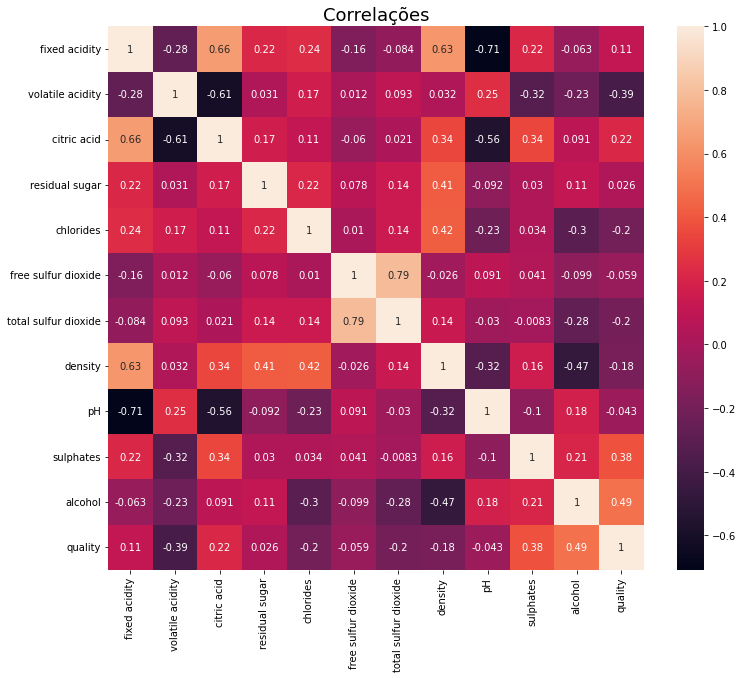

In [21]:
heatmap_corr(red)

Pelo mapa de calor acima, as variáveis que apresentam maior correlação com a qualidade são:
 - Correlação positiva:
     - alcohol
     - sulphates
 - Correlação negativa:
     - volatile acidity
     


In [22]:
# Distribuição dos valores da coluna 'quality'
red['quality'].value_counts(normalize = True)

5    0.424577
6    0.393672
7    0.122884
4    0.038999
8    0.012509
3    0.007358
Name: quality, dtype: float64

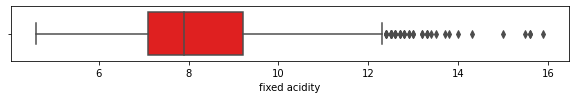

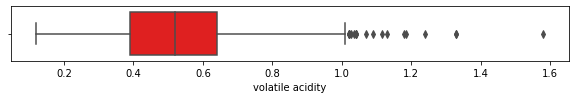

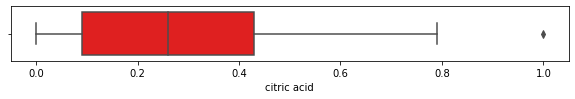

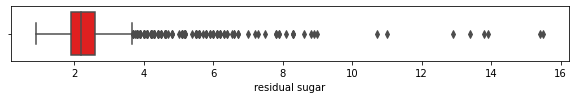

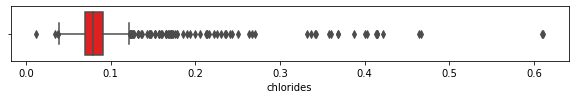

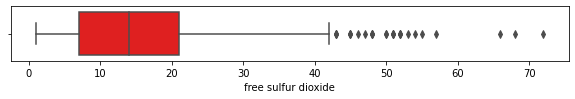

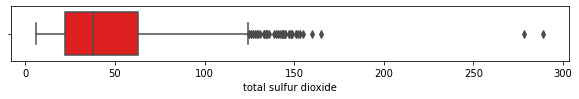

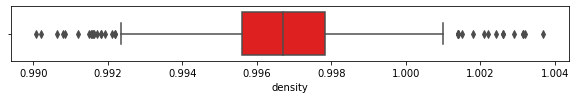

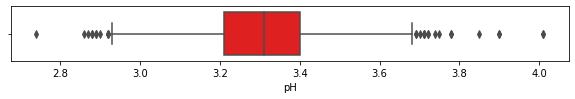

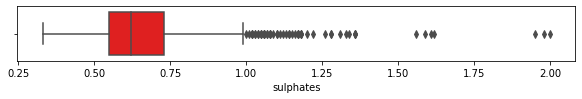

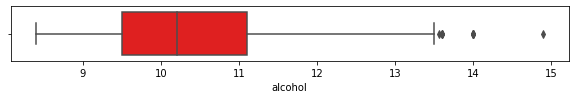

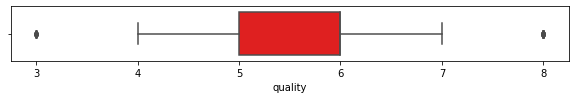

In [23]:
# Boxplot de cada uma das colunas
for col in red:
    plt.figure(figsize=(10,1))
    sns.boxplot(x = col, data = red, color = 'red')
plt.show()

In [24]:
# Medidas para avaliarmos outliers
avaliar_outlier(red, 'quality').head()

Avaliando os Outliers:
Primeiro Quartil:  5.0
Terceiro Quartil:  6.0
IQR:               1.0
Limite Inferior:   3.5
Limite Superior:   7.5

Frequência dos outliers da coluna quality:


8    17
3    10
Name: quality, dtype: int64

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
267            7.9              0.35         0.46             3.6      0.078   
278           10.3              0.32         0.45             6.4      0.073   
390            5.6              0.85         0.05             1.4      0.045   
440           12.6              0.31         0.72             2.2      0.072   
455           11.3              0.62         0.67             5.2      0.086   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
267                 15.0                  37.0   0.9973  3.35       0.86   
278                  5.0                  13.0   0.9976  3.23       0.82   
390                 12.0                  88.0   0.9924  3.56       0.82   
440                  6.0                  29.0   0.9987  2.88       0.82   
455                  6.0                  19.0   0.9988  3.22       0.69   

     alcohol  quality  
267     12.8        8  
278     12.6        8  
390     12.9        8  
440      9.8        8  
455     13.4        8

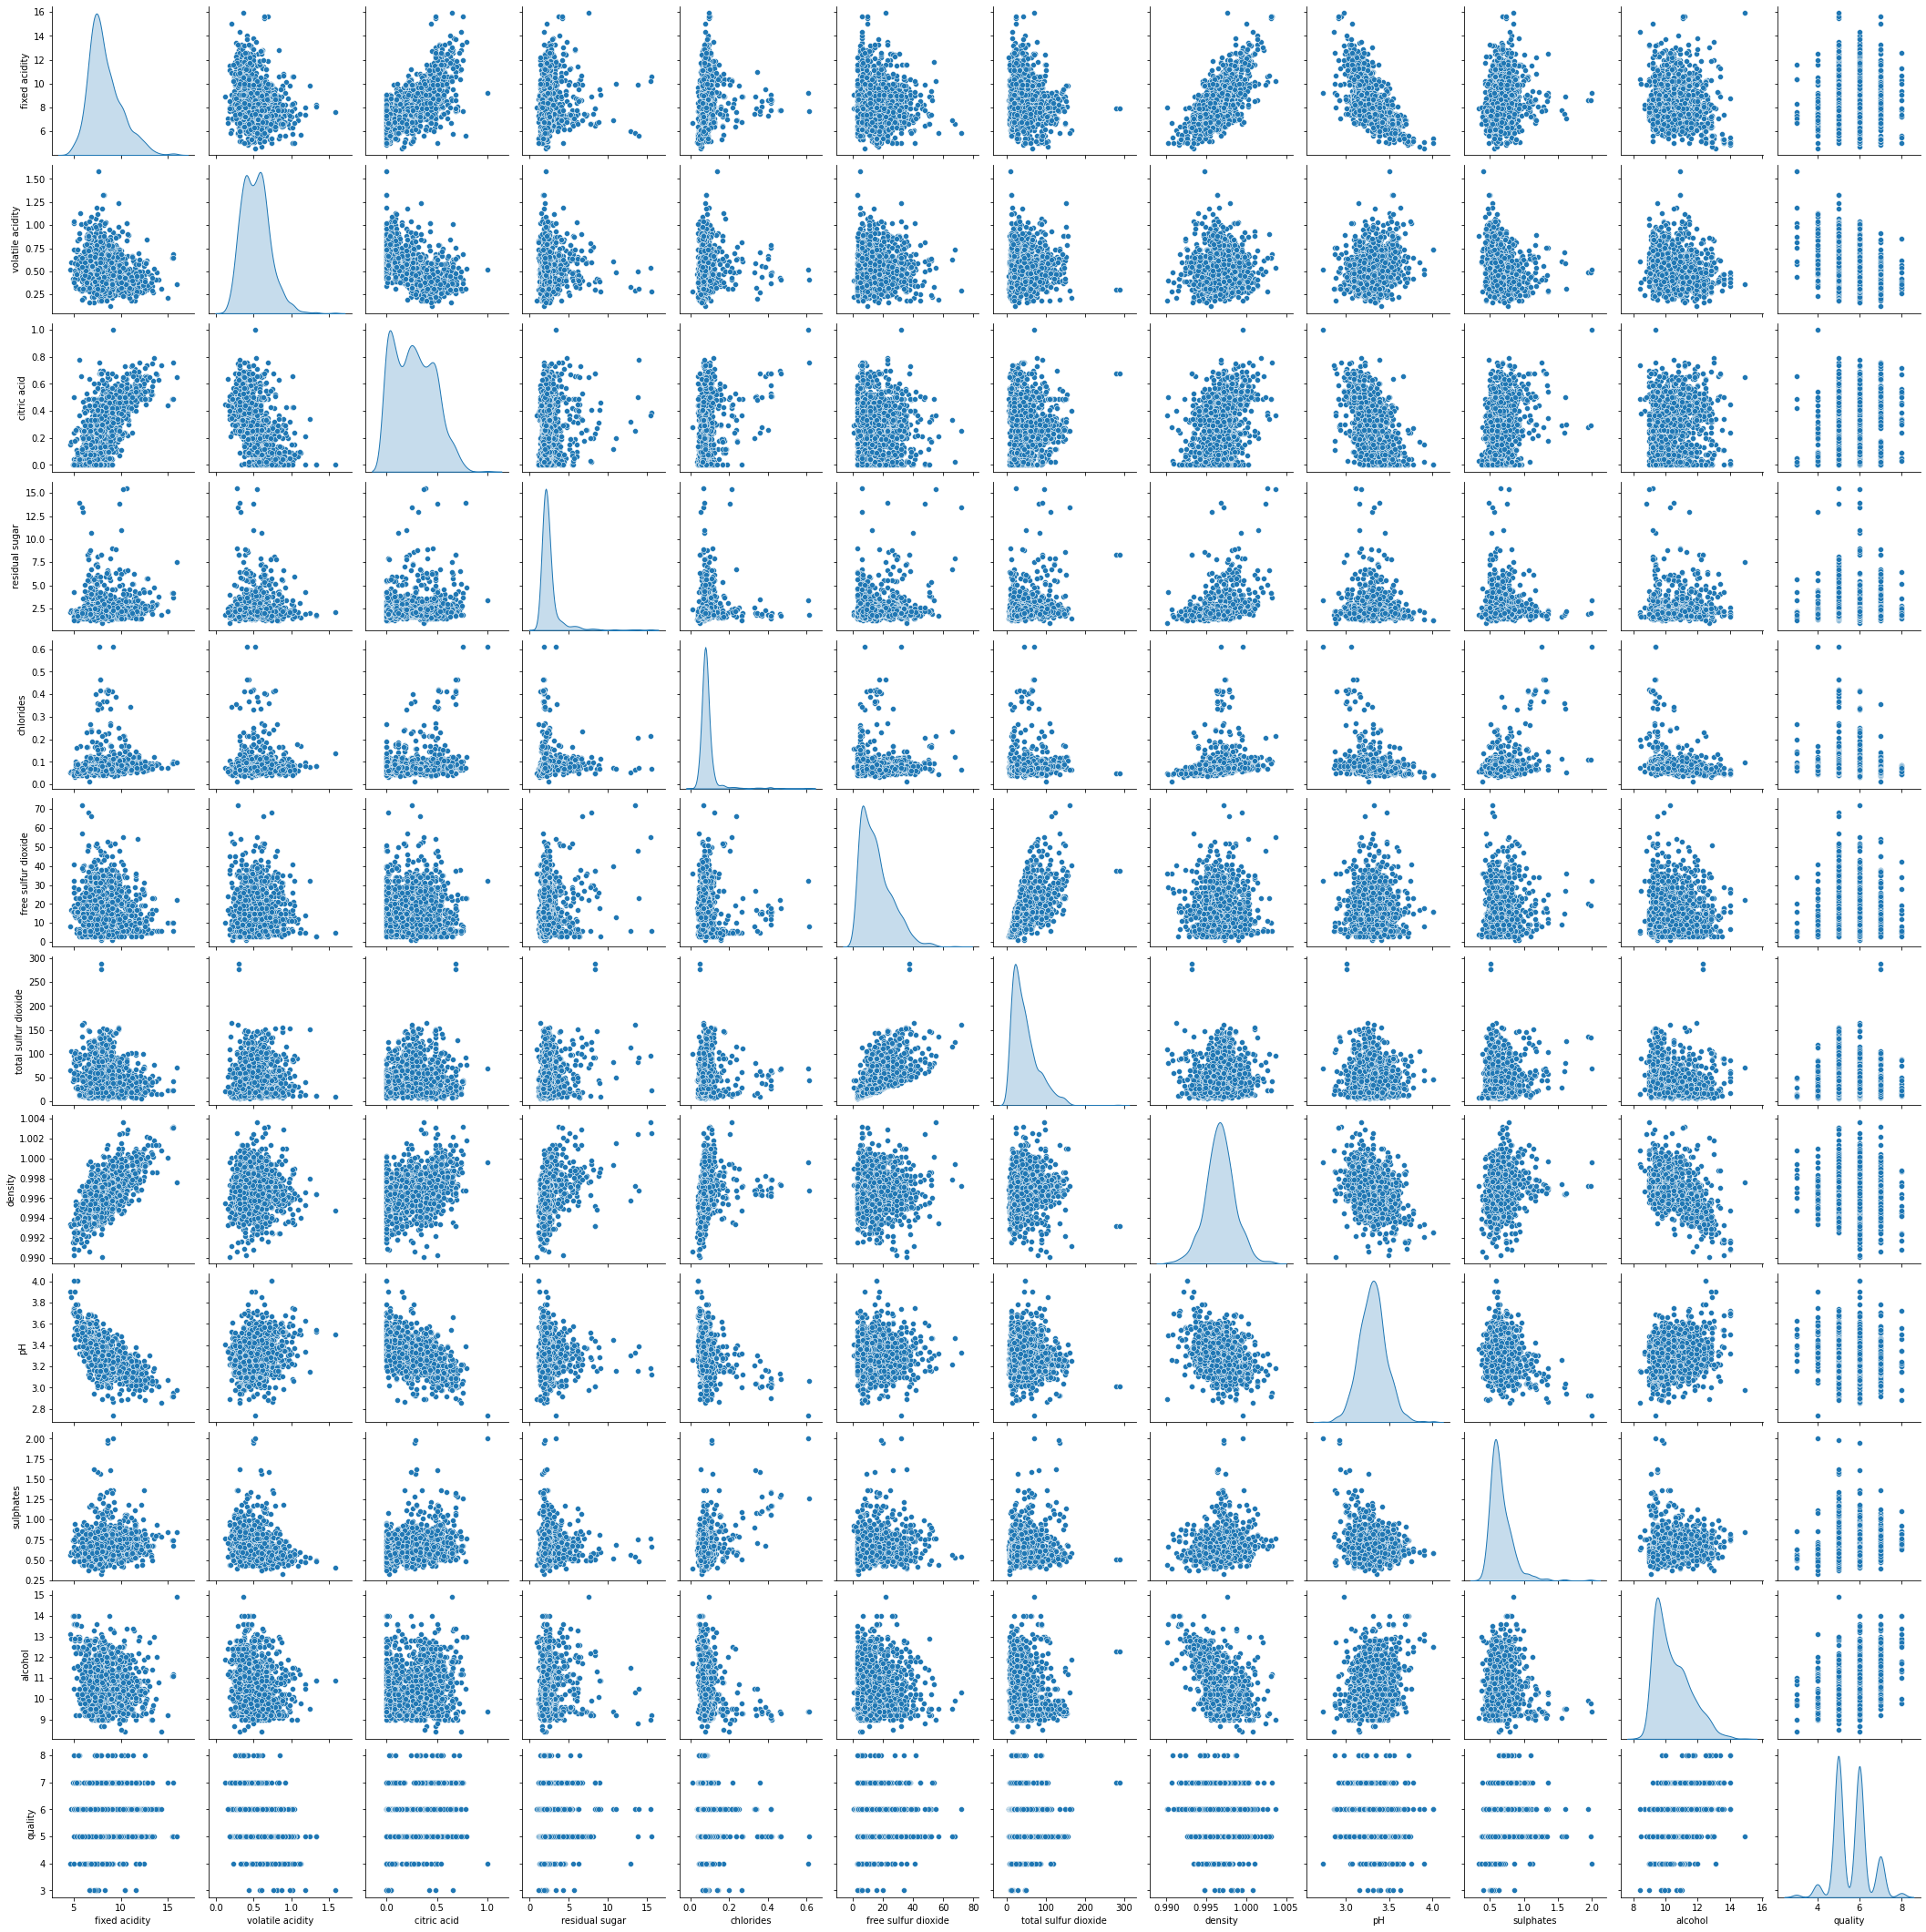

In [25]:
sns.pairplot(data = red, diag_kind = 'kde')

plt.show()

Através dos boxplots, dos valores de medidas centrais e do pairplot acima, verificamos que maioria dos dados apresentam distribuições assimétricas. Além disso, com a relação entre as variáveis plotadas acima, é muito difícil de perceber uma relação de correlação entre elas, corroborando com os dados apresentados no mapa de calor. <br>

Pelos boxplots podemos verificar também que há uma grande quantidade de outliers em cada feature. No entanto, se isolarmos a variável 'quality', percebemos que a nossa target é composta, em sua maioria, por vinhos que receberam nota entre 4 e 7, sendo a menor nota, 3, e a maior nota, 8, consideradas como outliers.




## Modelagem dos dados - Vinho tinto

### Vinho tinto - Regressão linear

In [26]:
# Separação em X e y
X_red = red.drop(['quality'], axis = 1)
y_red = red['quality']

In [27]:
# Modelo de regressão linear:

y_pred_red, y_test_red, red_model_lin = reg_lin(X_red, y_red)


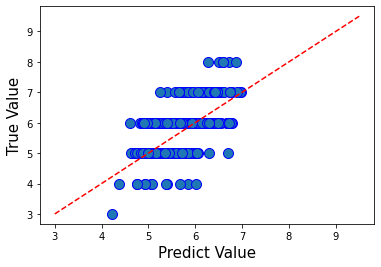

In [28]:
# Plot para comparar os valores reais com os preditos

plot_pred(y_pred_red, y_test_red)


In [29]:
# Métricas de avaliação para Regressão Linear
metricas(y_pred_red, y_test_red)

MAE: 0.47263164476337705
MSE: 0.36799002187364777
RMSE: 0.6066218112412772
R2 : 0.4040153429927623


In [30]:
# Score de cada feature
feat_importance(X_red, red_model_lin)

Score
alcohol               0.344676
sulphates             0.145040
density               0.011279
free sulfur dioxide   0.005379
residual sugar       -0.004405
citric acid          -0.023562
fixed acidity        -0.028535
total sulfur dioxide -0.053966
pH                   -0.096685
chlorides            -0.099246
volatile acidity     -0.202525

In [31]:
# Regressão Linear utilizando o método Ridge
red_y_pred_ridge, red_y_test_ridge, red_model_ridge = ridge(X_red, y_red)

In [32]:
# Score de cada feature após o método Ridge
feat_importance(X_red, red_model_ridge)

Score
alcohol               0.346146
sulphates             0.173860
free sulfur dioxide   0.059953
density               0.022448
fixed acidity        -0.001671
citric acid          -0.021382
residual sugar       -0.030595
chlorides            -0.086585
pH                   -0.090611
total sulfur dioxide -0.098483
volatile acidity     -0.201905

In [33]:
# Métricas de avaliação para o método Ridge
metricas(red_y_pred_ridge, red_y_test_ridge)

MAE: 0.5432071643324917
MSE: 0.496923562304267
RMSE: 0.7049280547008091
R2 : 0.22044741522714206


In [34]:
# Regressão Linear utilizando o método Lasso
red_y_pred_lasso, red_y_test_lasso, red_model_lasso = lasso(X_red, y_red, alpha_value = 0.2)

In [35]:
# Score de cada feature após o método Lasso
feat_importance(X_red, red_model_lasso)

Score
alcohol               0.196312
sulphates             0.006939
fixed acidity         0.000000
citric acid           0.000000
residual sugar       -0.000000
chlorides            -0.000000
free sulfur dioxide  -0.000000
total sulfur dioxide -0.000000
density              -0.000000
pH                   -0.000000
volatile acidity     -0.111337

In [36]:
# Métricas de avaliação para o método Lasso
metricas(red_y_pred_lasso, red_y_test_lasso)

MAE: 0.5824512489924585
MSE: 0.5091688979264891
RMSE: 0.7135607177574232
R2 : 0.2012374526496994


#### Considerações sobre a Regressão Linear para o vinho tinto

Dentre todas as features, o alcool é o que possui maior relevância para a regressão linear.

Analisando o R2 para a Regressão linear verificamos que apenas, aproximadamente, 40% do conjunto observado pode ser explicado pela predição do modelo de regressão linear.

Utilizando métodos de regularizações não melhorou o fit do modelo pois as métricas de erro aumentaram enquanto que o R2 diminuiu.

Além disso, se retirarmos algumas das variáveis com baixo índice de correlação com o valor da qualidade, o valor de R2 não terá alteração significativa.

Neste sentido, é possível concluir que boa parte das variáveis do dataframe de vinho tinto não possui grande relevância para avaliar a qualidade do vinho e somente este cojunto de variáveis não é suficiente para ter uma boa representação em uma regressão linear.

## Regressão logística - Vinho tinto

In [37]:
# Separar o target
red['target'] = np.where(red['quality'] < 6, 0, 1)

# Separação X e y
X = red.drop(['target', 'quality'], axis = 1)
y = red['target']

In [38]:
# Regressão logística
y_pred, y_test, model_log = reg_log(X, y)

In [39]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       192
           1       0.77      0.70      0.74       216

    accuracy                           0.73       408
   macro avg       0.73      0.73      0.73       408
weighted avg       0.74      0.73      0.73       408



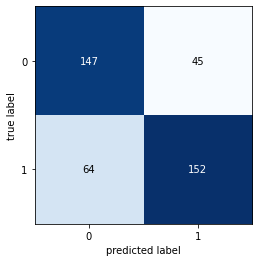

In [40]:
# Métricas de avaliação para regressão logística
metrica_reg_log(y_test, y_pred)

In [41]:
# Score de cada feature
feat_importance(X, model_log, tipo_regressao='logistica')

Score
alcohol               1.027708
sulphates             0.435743
free sulfur dioxide   0.196361
fixed acidity         0.119085
residual sugar       -0.014764
density              -0.051804
citric acid          -0.136331
pH                   -0.178191
chlorides            -0.214504
volatile acidity     -0.440563
total sulfur dioxide -0.500311

#### Considerações sobre a Regressão Logística para o vinho tinto

O alcool apresenta, novamente, o maior score. Este resultado era esperado, uma vez que o alcool possui o maior valore de correlação positiva com a qualidade.

O modelo possui um valor de 73% de acurácia, ou seja, possui 73% de classificações corretas do modelo. Além disso, possui valor de 77% de precisão (quanto dos verdadeiros positivos estão corretos) e 70% de sensibilidade (quanto dos casos positivos o classificador apontou como correto).

A regressão logística apresenta dados mais satisfatórios que a linear, sendo um modelo que se adequa melhor aos dados obtidos pelo dataframe.


# Vinho branco - Preparação dos dados, EDA e Modelagem

### Vinho branco - Preparação dos dados:

In [42]:
# Head da base de vinho branco

white.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [43]:
# Verificando dados faltantes para vinho branco
white.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [44]:
# Shape das bases

print('winequality-white shape:', white.shape)

winequality-white shape: (4898, 12)


In [45]:
# Removendo linhas duplicadas da base de vinho branco

white.drop_duplicates(inplace= True)

In [46]:
# Shape das bases

print('winequality-white shape:', white.shape)

winequality-white shape: (3961, 12)


A base de branco tinto possuía 937 linhas duplicadas que foram removidas para a análise abaixo,não possui dados faltantes e cada feature é composta por dados numéricos.

### Vinho branco - Análise exploratória dos dados

In [47]:
white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3961 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3961 non-null   float64
 1   volatile acidity      3961 non-null   float64
 2   citric acid           3961 non-null   float64
 3   residual sugar        3961 non-null   float64
 4   chlorides             3961 non-null   float64
 5   free sulfur dioxide   3961 non-null   float64
 6   total sulfur dioxide  3961 non-null   float64
 7   density               3961 non-null   float64
 8   pH                    3961 non-null   float64
 9   sulphates             3961 non-null   float64
 10  alcohol               3961 non-null   float64
 11  quality               3961 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 402.3 KB


In [48]:
white.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3961.000000       3961.000000  3961.000000     3961.000000   
mean        6.839346          0.280538     0.334332        5.914819   
std         0.866860          0.103437     0.122446        4.861646   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.600000   
50%         6.800000          0.260000     0.320000        4.700000   
75%         7.300000          0.330000     0.390000        8.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  3961.000000          3961.000000           3961.000000  3961.000000   
mean      0.045905            34.889169            137.193512     0.993790   
std       0.023103            17.210021             43.129065     0.002905   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.035000            23.000000            106.000000     0.991620   
50%       0.042000            33.000000            133.000000     0.993500   
75%       0.050000            45.000000            166.000000     0.995710   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  3961.000000  3961.000000  3961.000000  3961.000000  
mean      3.195458     0.490351    10.589358     5.854835  
std       0.151546     0.113523     1.217076     0.890683  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.480000    10.400000     6.000000  
75%       3.290000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000

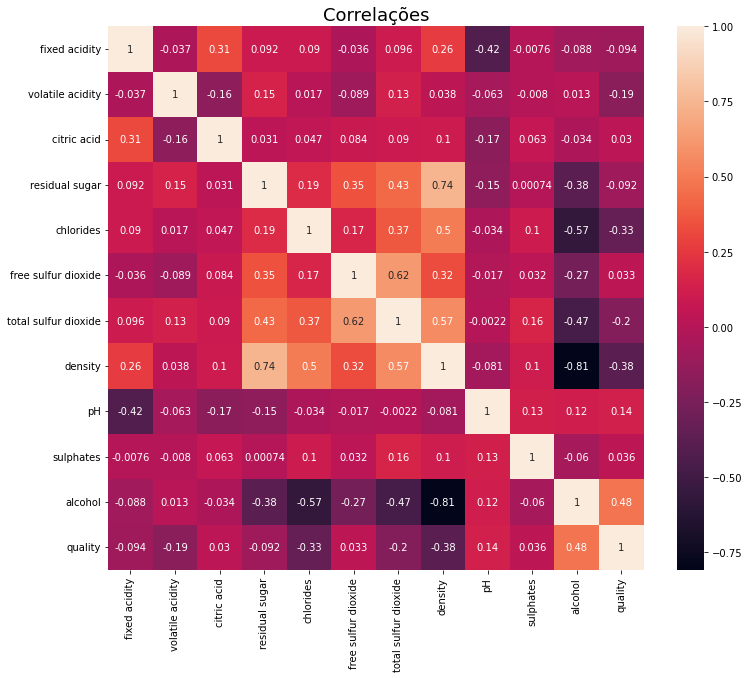

In [49]:
heatmap_corr(white)

Pelo mapa de calor acima, as variáveis que apresentam maior correlação com a qualidade são:

- Correlação positiva:
    - alcohol

- Correlação negativa:
    - density 
    - chlorides

In [50]:
# Distribuição dos valores da coluna 'quality'
white['quality'].value_counts(normalize = True)

6    0.451401
5    0.296642
7    0.173946
4    0.038627
8    0.033072
3    0.005049
9    0.001262
Name: quality, dtype: float64

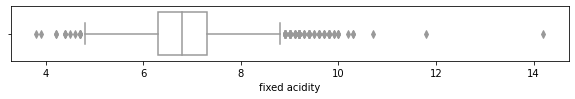

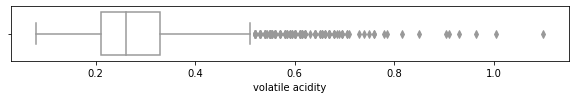

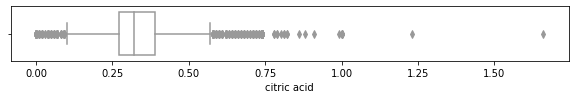

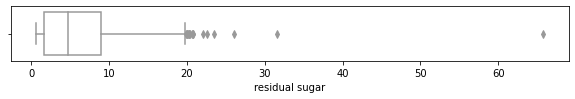

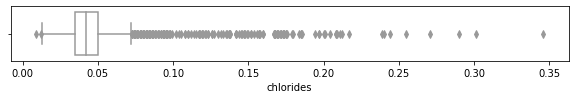

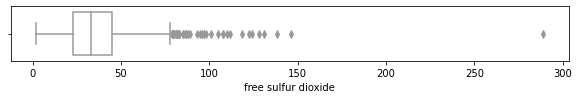

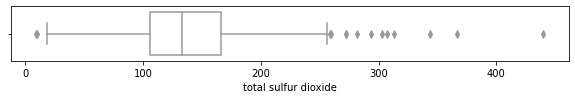

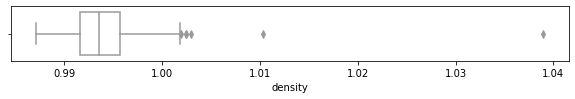

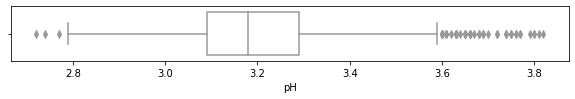

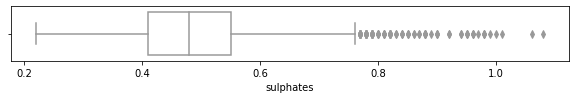

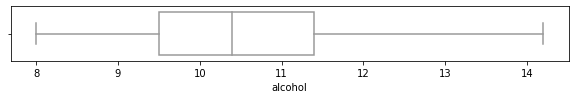

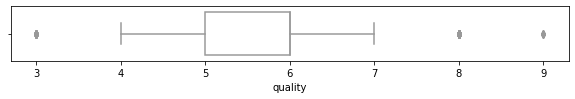

In [51]:
# Boxplot de cada uma das colunas
for col in white:
    plt.figure(figsize=(10,1))
    sns.boxplot(x = col, data = white, color = 'white')
plt.show()

In [52]:
# Medidas para avaliarmos outliers
avaliar_outlier(white, 'quality').head()

Avaliando os Outliers:
Primeiro Quartil:  5.0
Terceiro Quartil:  6.0
IQR:               1.0
Limite Inferior:   3.5
Limite Superior:   7.5

Frequência dos outliers da coluna quality:


8    131
3     20
9      5
Name: quality, dtype: int64

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
17             6.2              0.66         0.48             1.2      0.029   
22             6.8              0.26         0.42             1.7      0.049   
68             6.7              0.23         0.31             2.1      0.046   
158            5.2              0.44         0.04             1.4      0.036   
188            6.8              0.53         0.35             3.8      0.034   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
17                  29.0                  75.0   0.9892  3.33       0.39   
22                  41.0                 122.0   0.9930  3.47       0.48   
68                  30.0                  96.0   0.9926  3.33       0.64   
158                 43.0                 119.0   0.9894  3.36       0.33   
188                 26.0                 109.0   0.9906  3.26       0.57   

     alcohol  quality  
17      12.8        8  
22      10.5        8  
68      10.7        8  
158     12.1        8  
188     12.7        8

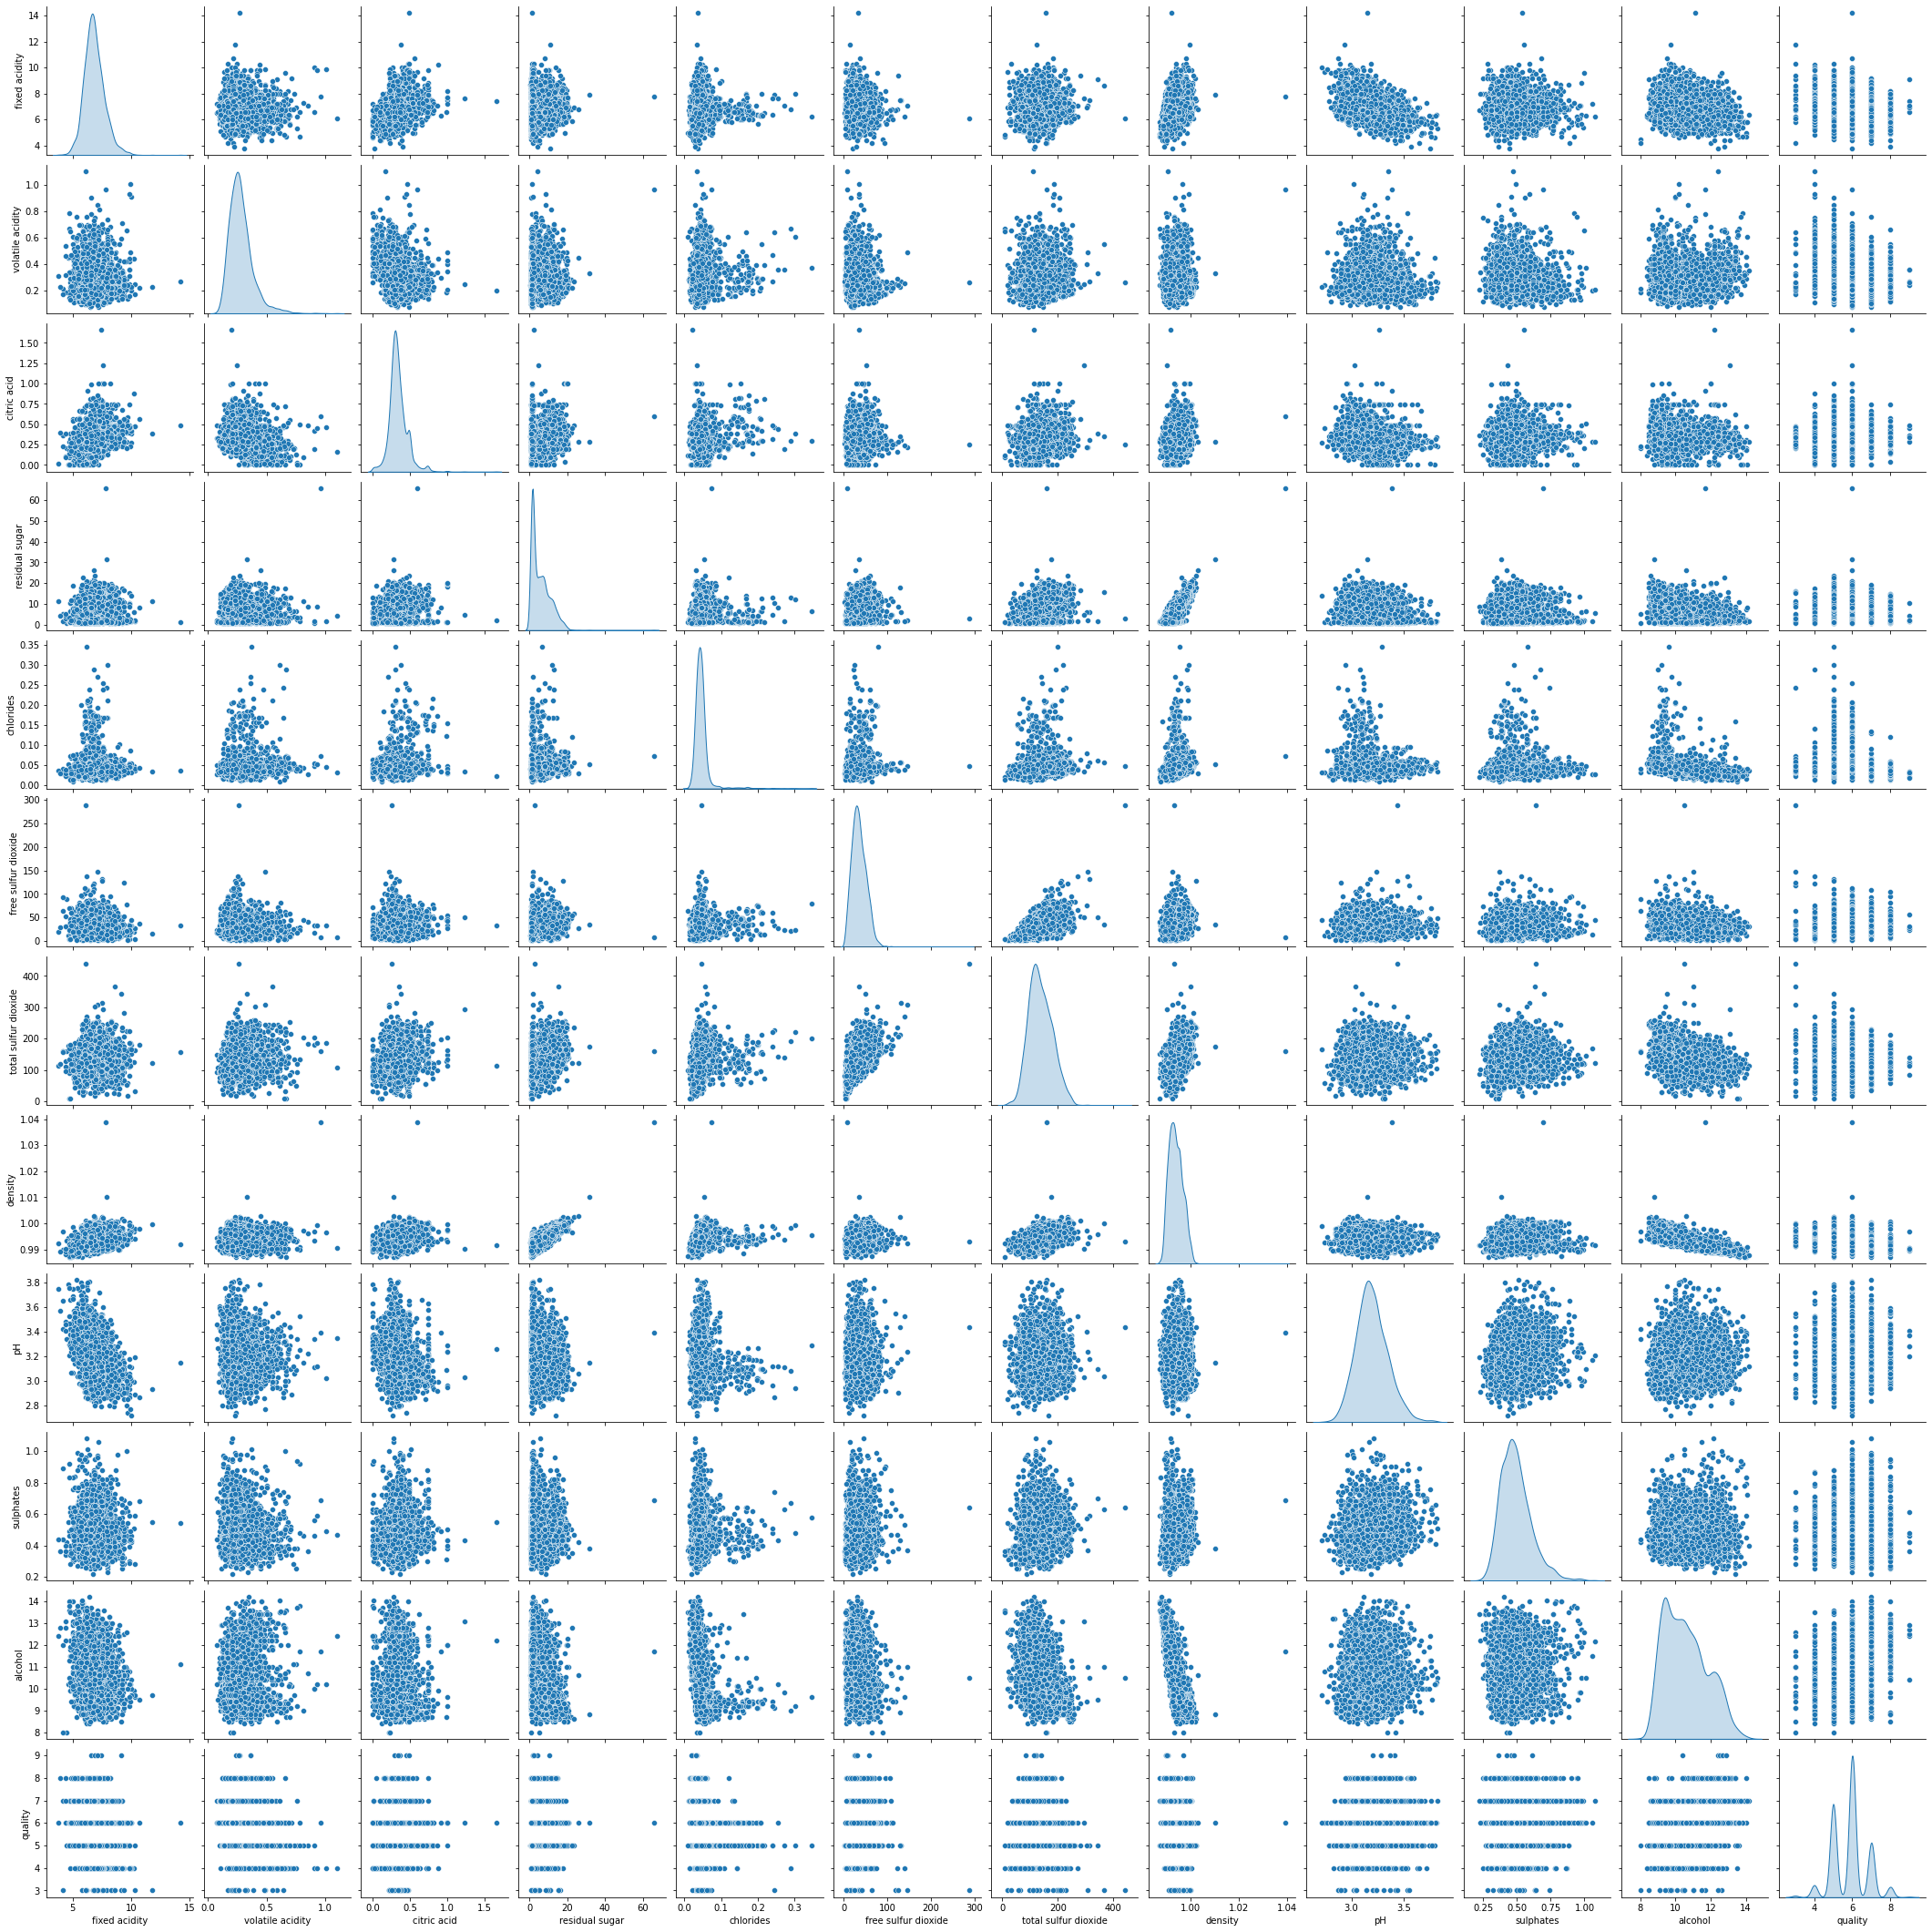

In [53]:
sns.pairplot(data = white, diag_kind = 'kde')

plt.show()

Da mesma forma que o banco de dados para vinho tinto, os boxplots, dos valores de medidas centrais e do pairplot acima, apontam que a maioria dos dados apresentam distribuições assimétricas. Além disso, com a relação entre as variáveis plotadas acima, é muito difícil de perceber uma relação de correlação entre a maior parte delas, corroborando com os dados apresentados no mapa de calor.

Pelos boxplots podemos verificar também que há uma grande quantidade de outliers em cada feature. No entanto, se isolarmos a variável 'quality', percebemos que a nossa target é composta, em sua maioria, por vinhos que receberam nota entre 4 e 7, sendo a menor nota, 3, e as maiores notas, 8 e 9, consideradas como outliers.

## Modelagem dos dados - Vinho branco

### Vinho branco - Regressão linear

In [54]:
# Separação em X e y
X_white = white.drop(['quality'], axis = 1)
y_white = white['quality']

In [55]:
# Modelo de regressão linear:

y_pred_white, y_test_white, white_model_lin = reg_lin(X_white, y_white)


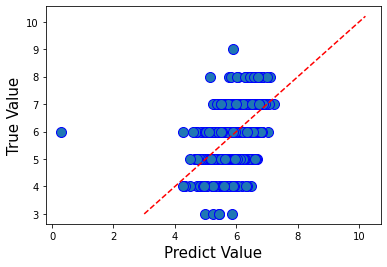

In [56]:
# Plot para comparar os valores reais com os preditos

plot_pred(y_pred_white, y_test_white)


In [57]:
# Métricas de avaliação
metricas(y_pred_white, y_test_white)

MAE: 0.5592537688635664
MSE: 0.5402838045103217
RMSE: 0.7350400019797029
R2 : 0.27517075632851584


In [58]:
# Score de cada feature

feat_importance(X_white, white_model_lin)

Score
residual sugar        0.522942
pH                    0.165959
fixed acidity         0.131292
sulphates             0.087969
alcohol               0.081897
free sulfur dioxide   0.046457
citric acid           0.034010
total sulfur dioxide  0.005605
chlorides            -0.016191
volatile acidity     -0.171597
density              -0.722718

In [59]:
# Regressão Linear utilizando o método Ridge
white_y_pred_ridge, white_y_test_ridge, white_model_ridge = ridge(X_white, y_white)

In [60]:
# Score de cada feature após o método Ridge
feat_importance(X_white, white_model_ridge)

Score
residual sugar        0.460292
pH                    0.157352
alcohol               0.140382
free sulfur dioxide   0.099797
sulphates             0.086351
fixed acidity         0.085012
citric acid           0.030028
chlorides            -0.013664
total sulfur dioxide -0.021851
volatile acidity     -0.167001
density              -0.609668

In [61]:
# Métricas de avaliação para o método Ridge
metricas(white_y_pred_ridge, white_y_test_ridge)

MAE: 0.568690450458325
MSE: 0.5521383352288174
RMSE: 0.7430601154878502
R2 : 0.2729527508736652


In [62]:
# Regressão Linear utilizando o método Lasso
white_y_pred_lasso, white_y_test_lasso, white_model_lasso = lasso(X_white, y_white, alpha_value = 0.2)

In [63]:
# Score de cada feature após o método Lasso
feat_importance(X_white, white_model_lasso)

Score
alcohol               0.206697
fixed acidity        -0.000000
volatile acidity     -0.000000
citric acid           0.000000
residual sugar       -0.000000
chlorides            -0.000000
free sulfur dioxide   0.000000
total sulfur dioxide -0.000000
density              -0.000000
pH                    0.000000
sulphates             0.000000

In [64]:
# Métricas de avaliação para o método Lasso
metricas(white_y_pred_lasso, white_y_test_lasso)

MAE: 0.6116127087707797
MSE: 0.6247114572399296
RMSE: 0.7903869035098757
R2 : 0.1773895824571443


#### Considerações sobre a Regressão Linear para o vinho branco

Dentre todas as features, o residual sugar é o que possui maior relevância para a regressão linear. No entanto, utilizando o método Lasso, o alcool é que apresenta o maior score.

Analisando o R2 para a Regressão linear verificamos que apenas, aproximadamente, 28% do conjunto observado pode ser explicado pela predição do modelo de regressão linear.

Utilizando métodos de regularizações não melhorou o fit do modelo pois as métricas de erro aumentaram enquanto que o R2 diminuiu.

Além disso, se retirarmos algumas das variáveis com baixo índice de correlação com o valor da qualidade, o valor de R2 não terá alteração significativa.

Neste sentido, é possível concluir que boa parte das variáveis do dataframe de vinho tinto não possui grande relevância para avaliar a qualidade do vinho e somente este cojunto de variáveis não é suficiente para ter uma boa representação em uma regressão linear.

## Regressão logística - Vinho branco

In [65]:
# xSeparar o target
white['target'] = np.where(white['quality'] < 6, 0, 1)

# Separação X e y
X = white.drop(['target', 'quality'], axis = 1)
y = white['target']

In [66]:
# Regressão logística
y_pred, y_test, model_log = reg_log(X, y)

In [67]:
y_pred

array([1, 1, 0, ..., 0, 1, 1])

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       405
           1       0.77      0.87      0.82       784

    accuracy                           0.74      1189
   macro avg       0.72      0.69      0.69      1189
weighted avg       0.73      0.74      0.73      1189



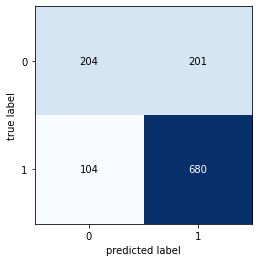

In [68]:
# Métricas de avaliação para regressão logística
metrica_reg_log(y_test, y_pred)

In [69]:
# Score de cada feature
feat_importance(X, model_log, tipo_regressao='logistica')

Score
alcohol               0.887878
residual sugar        0.731934
free sulfur dioxide   0.262937
sulphates             0.243750
pH                    0.200718
citric acid           0.083587
fixed acidity         0.033554
chlorides             0.000926
total sulfur dioxide -0.098785
volatile acidity     -0.543726
density              -0.803854

#### Considerações sobre a Regressão Logística para o vinho branco

O alcool apresenta o maior score positivo. A acidez volátil apresenta o maior score negativo. Além disso, o açúcar residual tem aparenta ser mais relevante do que na base de vinho tinto.

O modelo possui um valor de 75% de acurácia, ou seja, possui um valor de 75% de classificações corretas do modelo. Além disso, possui valor de 77% de precisão (quanto dos verdadeiros positivos estão corretos) e 86% de sensibilidade (quanto dos casos positivos o classificador apontou como correto). No entanto, pela matriz de confusão, podemos perceber que há uma quantidade relativamente grande de falsos negativos.

A regressão logística apresenta dados mais satisfatórios que a linear, sendo um modelo que se adequa melhor aos dados obtidos pelo dataframe.

# Vinho tinto + branco - Preparação dos dados, EDA e Modelagem

### Vinho tinto + branco - Preparação dos dados:

In [70]:
# Head da base de vinho tinto + branco
# 1 para red wine
# 0 para white wine
wine['red_wine'] = np.where(wine['wine_type'] == 'red', 1, 0)
wine.drop(['wine_type'], axis = 1, inplace = True)

wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  red_wine  
0      9.4        5         1  
1      9.8        5         1  
2      9.8        5         1  
3      9.8        6         1  
4      9.4        5         1

In [71]:
# Verificando dados faltantes para vinho tinto + branco
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
red_wine                0
dtype: int64

In [72]:
# Shape das bases

print('winequality:', wine.shape)

winequality: (6497, 13)


In [73]:
# Removendo linhas duplicadas da base de vinho tinto + branco

wine.drop_duplicates(inplace= True)

In [74]:
# Shape das bases

print('winequality shape:', wine.shape)

winequality shape: (5320, 13)


### Vinho tinto + branco - Análise exploratória dos dados

In [75]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5320 non-null   float64
 1   volatile acidity      5320 non-null   float64
 2   citric acid           5320 non-null   float64
 3   residual sugar        5320 non-null   float64
 4   chlorides             5320 non-null   float64
 5   free sulfur dioxide   5320 non-null   float64
 6   total sulfur dioxide  5320 non-null   float64
 7   density               5320 non-null   float64
 8   pH                    5320 non-null   float64
 9   sulphates             5320 non-null   float64
 10  alcohol               5320 non-null   float64
 11  quality               5320 non-null   int64  
 12  red_wine              5320 non-null   int32  
dtypes: float64(11), int32(1), int64(1)
memory usage: 561.1 KB


In [76]:
wine.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    5320.000000       5320.000000  5320.000000     5320.000000   
mean        7.215179          0.344130     0.318494        5.048477   
std         1.319671          0.168248     0.147157        4.500180   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.240000        1.800000   
50%         7.000000          0.300000     0.310000        2.700000   
75%         7.700000          0.410000     0.400000        7.500000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  5320.000000          5320.000000           5320.000000  5320.000000   
mean      0.056690            30.036654            114.109023     0.994535   
std       0.036863            17.805045             56.774223     0.002966   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            16.000000             74.000000     0.992200   
50%       0.047000            28.000000            116.000000     0.994650   
75%       0.066000            41.000000            153.250000     0.996770   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality     red_wine  
count  5320.000000  5320.000000  5320.000000  5320.000000  5320.000000  
mean      3.224664     0.533357    10.549241     5.795677     0.255451  
std       0.160379     0.149743     1.185933     0.879772     0.436155  
min       2.720000     0.220000     8.000000     3.000000     0.000000  
25%       3.110000     0.430000     9.500000     5.000000     0.000000  
50%       3.210000     0.510000    10.400000     6.000000     0.000000  
75%       3.330000     0.600000    11.400000     6.000000     1.000000  
max       4.010000     2.000000    14.900000     9.000000     1.000000

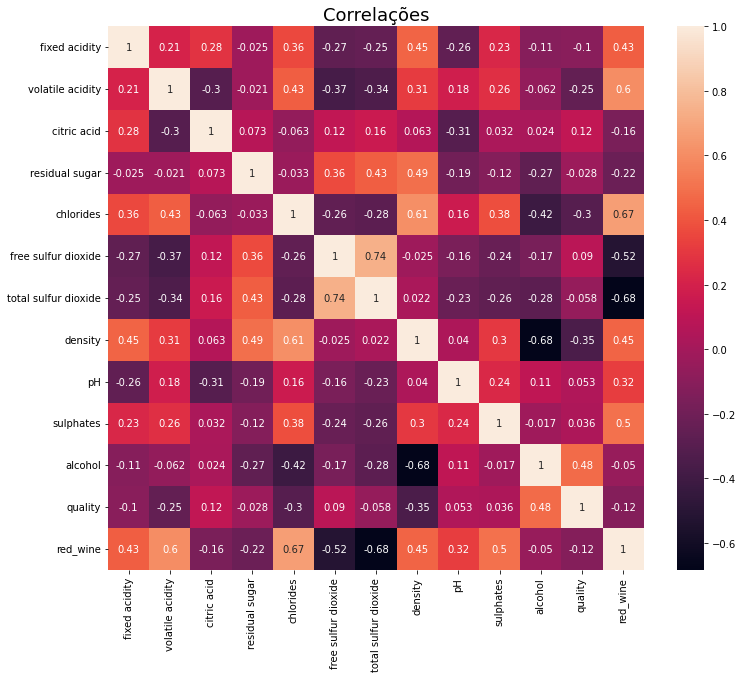

In [77]:
heatmap_corr(wine)

In [78]:
# Distribuição dos valores da coluna 'quality'
wine['quality'].value_counts(normalize = True)

6    0.436654
5    0.329323
7    0.160902
4    0.038722
8    0.027820
3    0.005639
9    0.000940
Name: quality, dtype: float64

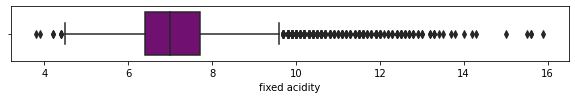

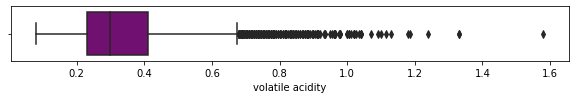

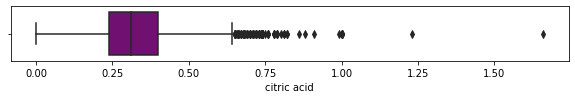

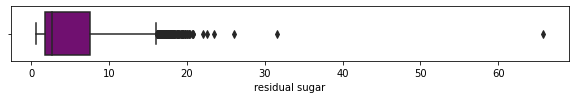

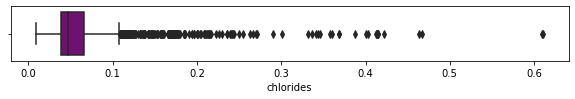

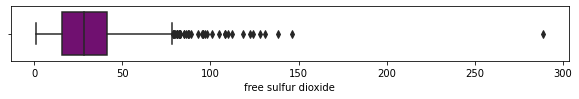

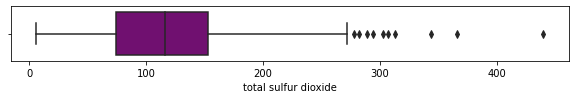

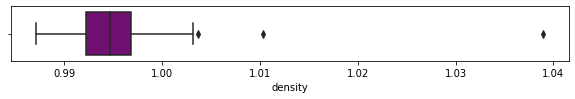

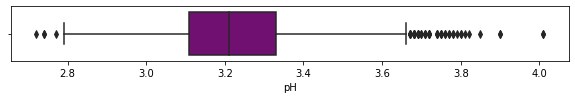

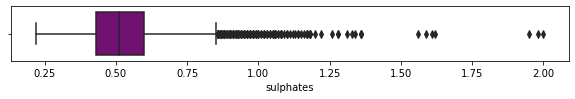

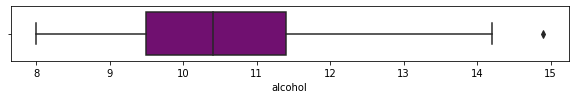

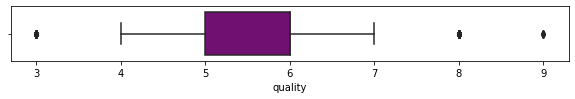

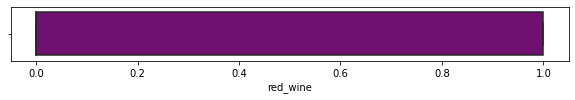

In [79]:
# Boxplot de cada uma das colunas
for col in wine:
    plt.figure(figsize=(10,1))
    sns.boxplot(x = col, data = wine, color = 'purple')
plt.show()

In [80]:
# Medidas para avaliarmos outliers
avaliar_outlier(wine, 'quality').head()

Avaliando os Outliers:
Primeiro Quartil:  5.0
Terceiro Quartil:  6.0
IQR:               1.0
Limite Inferior:   3.5
Limite Superior:   7.5

Frequência dos outliers da coluna quality:


8    148
3     30
9      5
Name: quality, dtype: int64

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
267            7.9              0.35         0.46             3.6      0.078   
278           10.3              0.32         0.45             6.4      0.073   
390            5.6              0.85         0.05             1.4      0.045   
440           12.6              0.31         0.72             2.2      0.072   
455           11.3              0.62         0.67             5.2      0.086   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
267                 15.0                  37.0   0.9973  3.35       0.86   
278                  5.0                  13.0   0.9976  3.23       0.82   
390                 12.0                  88.0   0.9924  3.56       0.82   
440                  6.0                  29.0   0.9987  2.88       0.82   
455                  6.0                  19.0   0.9988  3.22       0.69   

     alcohol  quality  red_wine  
267     12.8        8         1  
278     12.6        8         1  
390     12.9        8         1  
440      9.8        8         1  
455     13.4        8         1

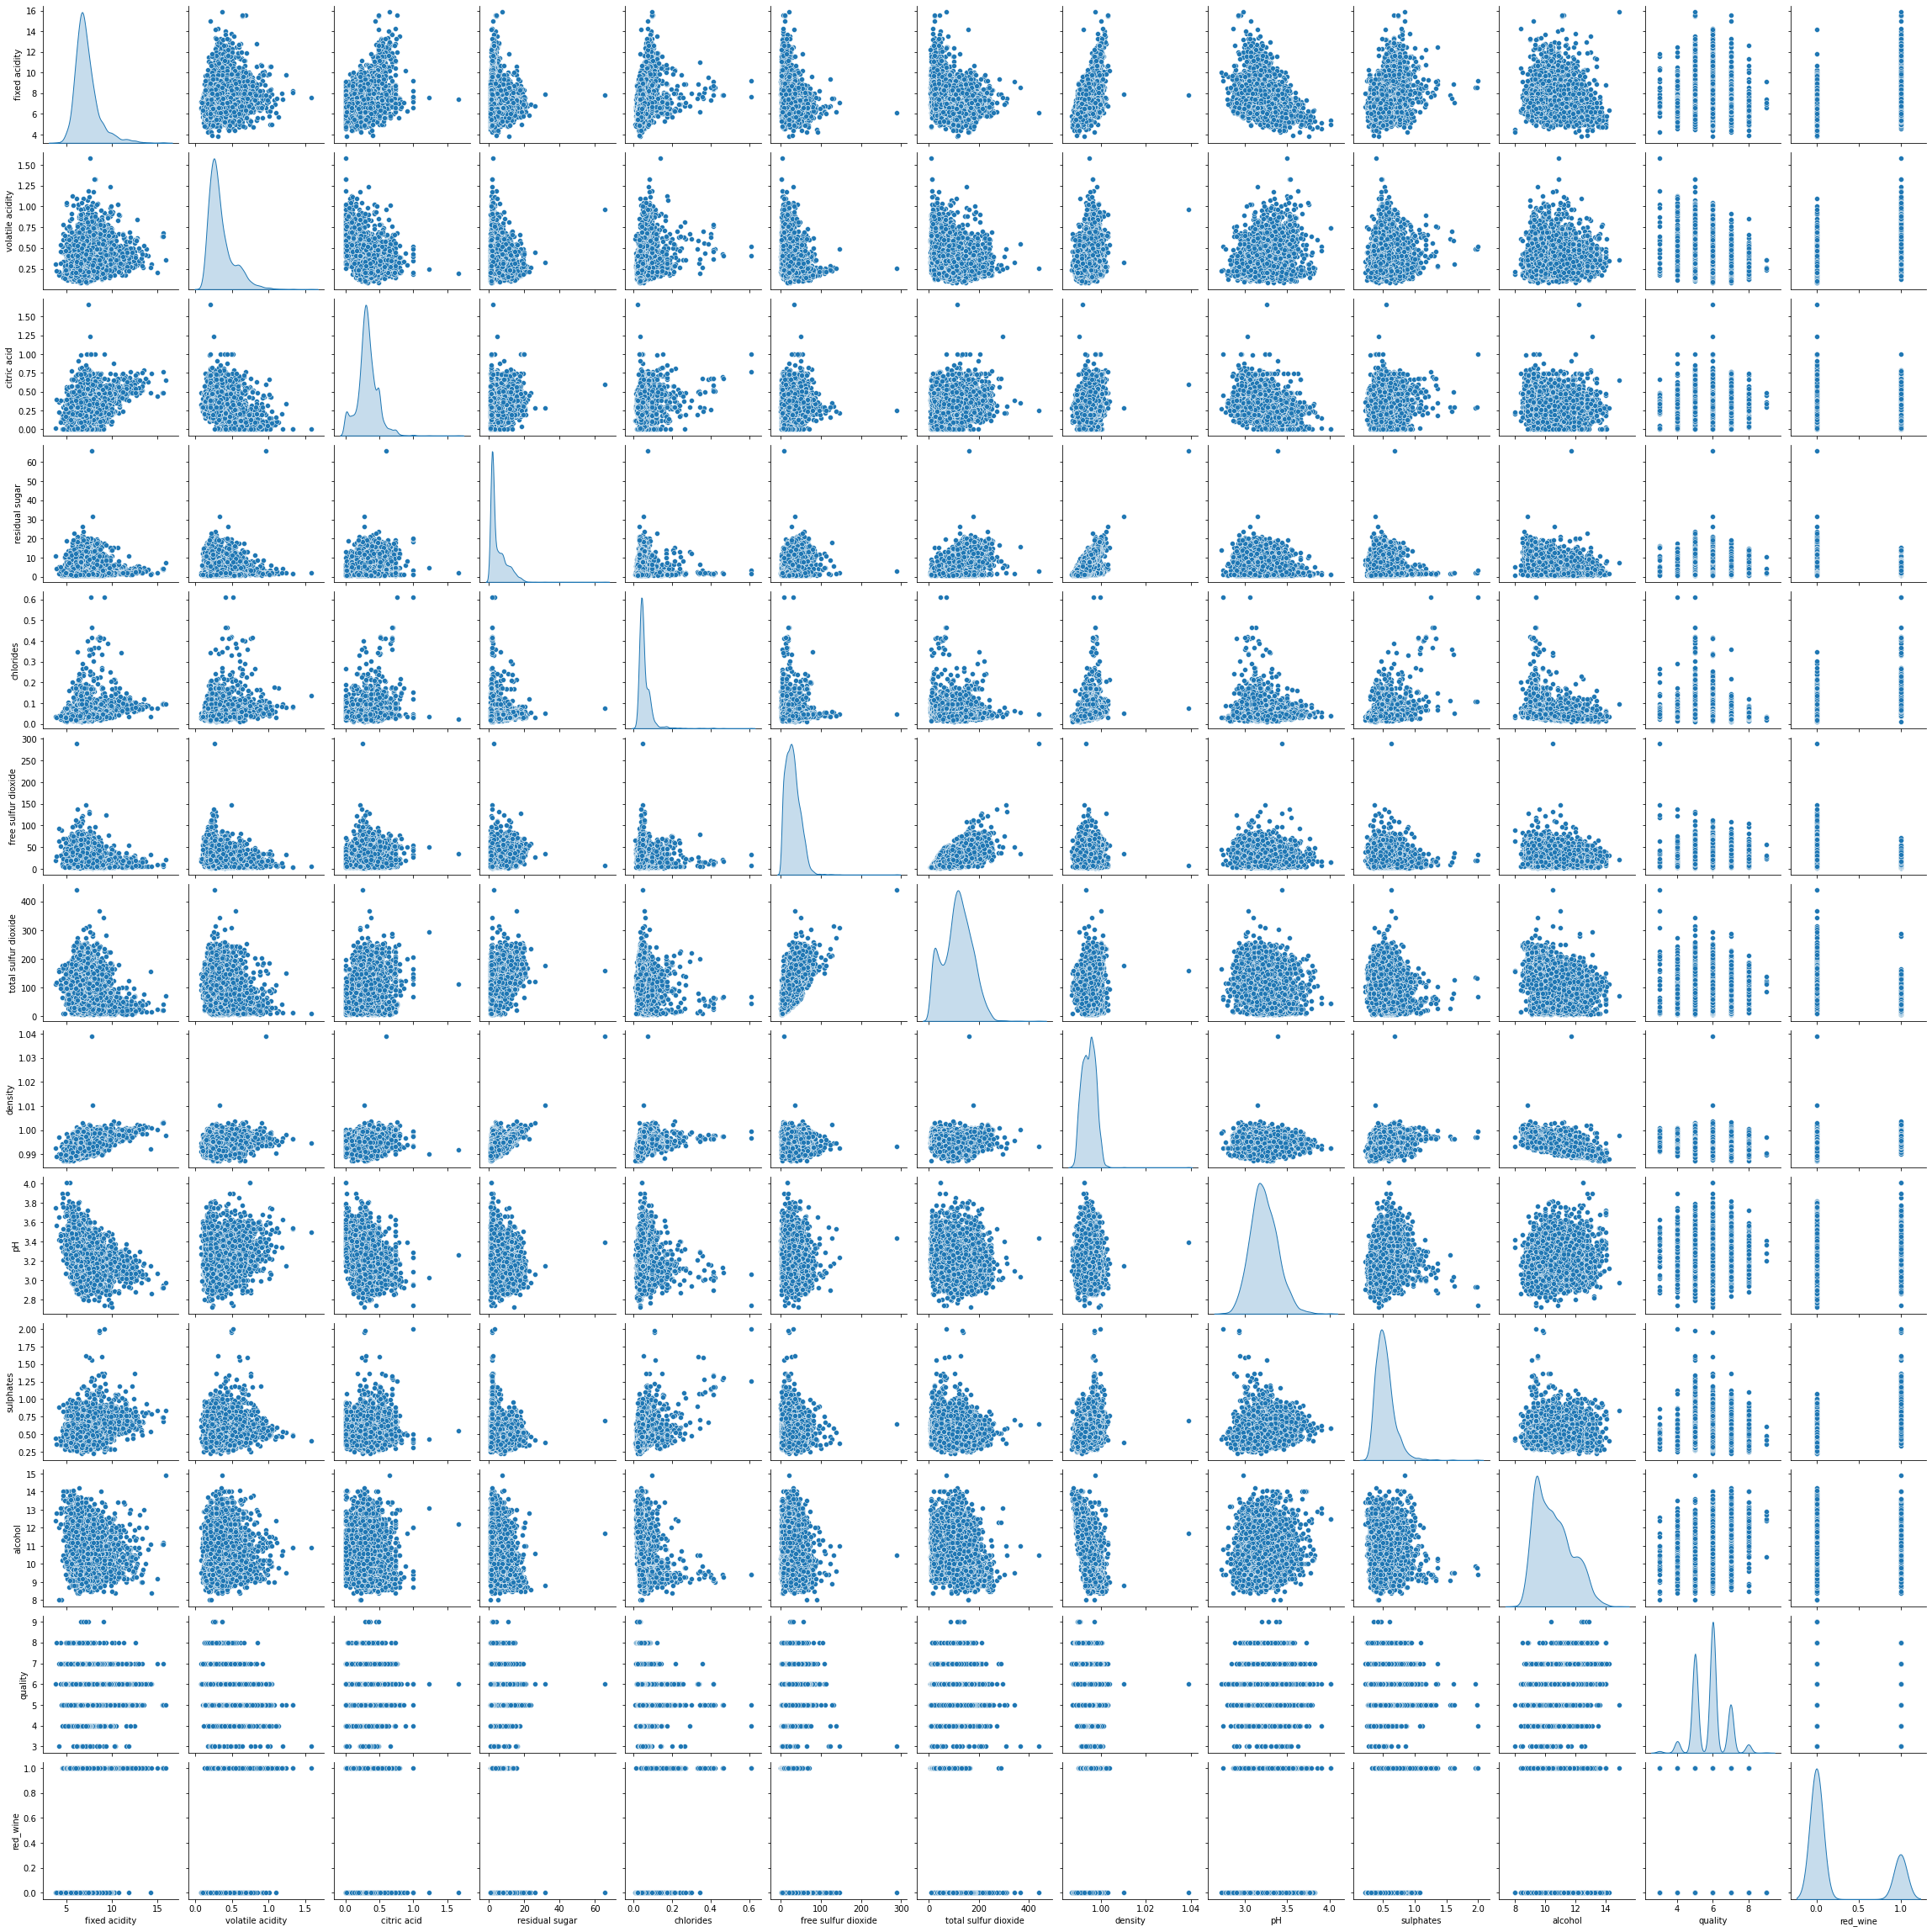

In [81]:
sns.pairplot(data = wine, diag_kind = 'kde')

plt.show()

A união das base de dados não influenciou o suficiente a alterar o comportamento dos dados de forma significativa. Podemos, assim, perceber as mesmas características, tal como:

 - Maioria de distribuições assimétricas;
 - Não há uma correlação muito evidente entre as variáveis;
 - A distribuição de outliers para a qualidade do vinho permanece a mesma, a maioria recebeu nota entre 4 e 7, sendo a menor nota, 3, e as maiores notas, 8 e 9, consideradas como outliers.


## Modelagem dos dados - Vinho tinto + branco

### Vinho tinto + branco - Regressão linear

In [82]:
# Separação em X e y
X_wine = wine.drop(['quality'], axis = 1)
y_wine = wine['quality']

In [83]:
# Modelo de regressão linear:

y_pred_wine, y_test_wine, wine_model_lin = reg_lin(X_wine, y_wine)


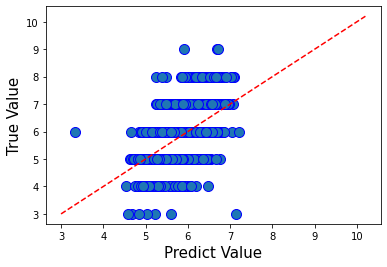

In [84]:
# Plot para comparar os valores reais com os preditos

plot_pred(y_pred_wine, y_test_wine)


In [85]:
# Métricas de avaliação
metricas(y_pred_wine, y_test_wine)

MAE: 0.5647636827349545
MSE: 0.5292039851573931
RMSE: 0.7274640782591214
R2 : 0.3273344576438417


In [86]:
feat_importance(X_wine, wine_model_lin)

Score
residual sugar        0.254937
alcohol               0.232305
red_wine              0.161001
fixed acidity         0.127436
free sulfur dioxide   0.111510
sulphates             0.110666
pH                    0.098927
citric acid           0.021942
chlorides            -0.038888
total sulfur dioxide -0.082067
volatile acidity     -0.214143
density              -0.351358

In [87]:
# Regressão Linear utilizando o método Ridge
wine_y_pred_ridge, wine_y_test_ridge, wine_model_ridge = ridge(X_wine, y_wine)

In [88]:
# Score de cada feature após o método Ridge
feat_importance(X_wine, wine_model_ridge)

Score
alcohol               0.283495
residual sugar        0.212764
red_wine              0.119144
free sulfur dioxide   0.108125
sulphates             0.103045
pH                    0.084538
fixed acidity         0.083682
citric acid           0.014723
chlorides            -0.039020
total sulfur dioxide -0.096364
volatile acidity     -0.222742
density              -0.257999

In [89]:
# Métricas de avaliação para o método Ridge
metricas(wine_y_pred_ridge, wine_y_test_ridge)

MAE: 0.5633862361290629
MSE: 0.5253722038531841
RMSE: 0.7248256368625382
R2 : 0.31058929891383313


In [90]:
# Regressão Linear utilizando o método Lasso
wine_y_pred_lasso, wine_y_test_lasso, wine_model_lasso = lasso(X_wine, y_wine, alpha_value = 0.2)

In [91]:
# Score de cada feature após o método Lasso
feat_importance(X_wine, wine_model_lasso)

Score
alcohol               0.213757
fixed acidity        -0.000000
citric acid           0.000000
residual sugar        0.000000
chlorides            -0.000000
free sulfur dioxide   0.000000
total sulfur dioxide  0.000000
density              -0.000000
pH                    0.000000
sulphates             0.000000
red_wine             -0.000000
volatile acidity     -0.023748

In [92]:
# Métricas de avaliação para o método Lasso
metricas(wine_y_pred_lasso, wine_y_test_lasso)

MAE: 0.6254173853686109
MSE: 0.6285505173212762
RMSE: 0.7928117792523496
R2 : 0.1751953193632827


#### Considerações sobre a Regressão Linear para a união das bases de vinho tinto e vinho branco

Dentre todas as features, o alcool e o açúcar residual são os que apresentam maior relevância para a regressão linear.

Com a união das bases, os resultados da Regressão Linear não apresentam alterações significativas:
 - R2 ainda apresenta um valor baixo, de 32% apenas; e
 - Os métodos de regularizações não ajudaram no fit do modelo, apresentando maiores valores para os erros e menor R2.

Neste sentido, conforme esperado, é possível concluir que boa parte das variáveis do dataframe dos vinhos não possui grande relevância para avaliar a qualidade do vinho e somente este cojunto de variáveis não é suficiente para ter uma boa representação em uma regressão linear.

## Regressão logística - Vinho tinto + branco

In [93]:
# Separar o target
wine['target'] = np.where(wine['quality'] < 6, 0, 1)

# Separação X e y
X = wine.drop(['target', 'quality'], axis = 1)
y = wine['target']

In [94]:
# Regressão Logística
y_pred, y_test, model_log = reg_log(X, y)

In [95]:
y_pred

array([0, 0, 1, ..., 0, 0, 0])

              precision    recall  f1-score   support

           0       0.70      0.58      0.63       596
           1       0.77      0.86      0.81      1000

    accuracy                           0.75      1596
   macro avg       0.74      0.72      0.72      1596
weighted avg       0.75      0.75      0.75      1596



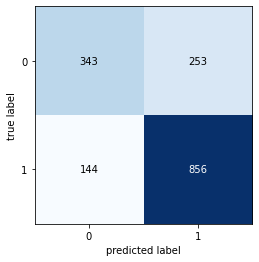

In [96]:
# Métricas de avaliação para regressão logística
metrica_reg_log(y_test, y_pred)

In [97]:
# Score de cada feature
feat_importance(X, model_log, tipo_regressao='logistica')

Score
alcohol               0.949995
residual sugar        0.403008
sulphates             0.313859
free sulfur dioxide   0.283245
red_wine              0.198820
pH                    0.145739
fixed acidity         0.119945
citric acid          -0.010547
chlorides            -0.050929
total sulfur dioxide -0.302250
density              -0.378187
volatile acidity     -0.706593

#### Considerações sobre a Regressão Logística para o vinho tinto + branco

Talvez pela base de vinho branco ser muito maior que a base de vinho tinto, os dados apresentaram um comportamento um pouco mais parecido com a base de vinho branco. O alcool apresenta o maior score positivo. A acidez volátil apresenta o maior score negativo. Além disso, o açúcar residual tem uma presença maior que na base de vinho tinto

Sobre as métricas, ficaram muito parecidas com a base de vinho branco, ou seja, 75% de acurácia, 77% de precisão e 86% de sensibilidade. No entanto, este modelo apresentou menos falso negativos que o modelo de vinho branco.

Novamente, a regressão logística apresenta dados mais satisfatórios que a linear, mantendo a conclusão de que é um modelo que se adequa melhor aos dados obtidos pelo dataframe.

### Conclusão:

O fato de notas baixas e altas estarem apenas como outliers, apontam que a falta de dados que resultem nestas notas acabaram atrapalhando para obter uma maior precisão do modelo de regressão linear.

Ainda, por existirem muitas variáveis que não possuem uma correlação forte com a target, as penalizações das regularizações acabaram diminuindo o valor do R2 e aumentando os erros por influência dessas variáveis.

Pela falta de dados mais relevantes para definir com maior precisão a nota da qualidade do vinho, a regressão linear ficou um pouco comprometida, não sendo suficiente para prever a qualidade de forma satisfatória. Contudo, classificando o vinho como bom (qualidade >=6) ou ruim (qualidade < 6), o modelo de regressão logística apresentou métricas de avaliação  melhores.